In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats
import sys; sys.path.insert(1, '/home/matteo/Eureca/COARE35/functions')
import geometry as gm
import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
from coare_functions import *
import meteo
import lcl
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
from plotmap import plot_background
from plotdistr import perc_distribution,perc_distribution_pvalue,perc_distribution_pvalue_dof
import warnings; warnings.filterwarnings("ignore")

In [7]:
# find data
path = '/media/matteo/DAGOBAH/WRF_EUREC4A/CNT/FEB/01/'
wrf_files = path + 'wrfout_d02_2020-0'
fname_list = sorted(glob.glob(wrf_files + '*'))

In [8]:
minlon = -60.; maxlon = -51.
minlat = 0.; maxlat = 17.

In [9]:
# open data
ds_tot = xr.open_mfdataset(fname_list, concat_dim='Time', combine='nested')

In [10]:
# select domain
mask_lon = (ds_tot.XLONG >= minlon) & (ds_tot.XLONG <= maxlon)
mask_lat = (ds_tot.XLAT >= minlat) & (ds_tot.XLAT <= maxlat)
ds = ds_tot.where(mask_lon & mask_lat, drop=True)

In [11]:
# def lon lat time
lon = ds['XLONG'][0].values
lat = ds['XLAT'][0].values
time = ds['XTIME'].values.astype('<M8[s]')
# land - sea mask
lakemask = ds['LAKEMASK'][0].values
landmask = ds['LANDMASK'][0].values
seamask = 1 - lakemask - landmask
seamask[seamask==0] = np.nan
# def extended land-sea mask
seamask_nocoast = seamask.copy(); seamask_island0 = seamask.copy()
seamask_island0[:int(seamask_island0.shape[0]/2),:] = 1
seamask_island = seamask_island0.copy()
for i in range(0,5):
    for j in range(0,5):
        seamask_nocoast = np.roll(seamask, (i,j), axis=(1,0))*seamask_nocoast
        seamask_island = np.roll(seamask_island0, (-i,-j), axis=(1,0))*seamask_island
seamask_nocoast = seamask_nocoast*seamask_island
seamask = seamask_nocoast.copy()

In [8]:
GP = (ds['P'][10]+ds['PB'][10])*seamask/100.
GP = np.nanmean(GP, axis=(1,2))

In [9]:
GPH = (ds['PH'][10]+ds['PHB'][10])*seamask/9.81
GPH = np.nanmean(GPH, axis=(1,2))

In [12]:
# daily varaibles
# select sst, q2, U, PBLH
sst_day = ds['SST'].groupby('XTIME.day').mean().values*seamask

In [13]:
# compute anomalies daily data
s = 50
dsst_day = np.zeros(sst_day.shape)
for t in range(0,sst_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    sst_ave = gm.nan_gaussian_filter(sst_day[t],s)*seamask
    dsst_day[t] = sst_day[t] - sst_ave

0
10
20


In [ ]:
# # hourly varaibles
# # select sst, q2, U, PBLH
# sst = ds['SST'].values*seamask

In [ ]:
# # compute anomalies hourly data
# s = 50
# dsst = np.zeros(sst.shape)
# for t in range(0,sst.shape[0]):
#     if t % 50 == 0:
#         print(t)
#     # upscale using gaussian filter
#     sst_ave = gm.nan_gaussian_filter(sst[t],s)*seamask
#     dsst[t] = sst[t] - sst_ave

In [ ]:
# read QVAPOR DAY from QVAPOR dataset
path_dir = '/media/fabien/DAGOBAH/WRF_EUREC4A/CNT/FEB/01_var_33levels/'
ds_tmp = xr.open_dataset(path_dir + 'QVAPOR_d02_2020-02')
maskl_lon = (ds_tmp.XLONG >= minlon) & (ds_tmp.XLONG <= maxlon)
maskl_lat = (ds_tmp.XLAT >= minlat) & (ds_tmp.XLAT <= maxlat)
ds_tmp = ds_tmp.where(maskl_lon & maskl_lat, drop=True)
QVAPOR_day = ds_tmp['QVAPOR'].groupby('XTIME.day').mean().values*seamask
del ds_tmp

In [14]:
# read QVAPOR DAY from hourly wrfout
# QVAPOR_day = ds['QVAPOR'][:,:50].groupby('XTIME.day').mean().values*seamask
QVAPOR_day = ds['QVAPOR'].groupby('XTIME.day').mean().values*seamask

KeyboardInterrupt: 

In [ ]:
# compute anomalies daily data
s = 50
dQVAPOR_day = np.zeros(QVAPOR_day.shape)
for t in range(0,QVAPOR_day.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    for h in range(0,QVAPOR_day.shape[1]):
        q_ave = gm.nan_gaussian_filter(QVAPOR_day[t,h],s)*seamask
        dQVAPOR_day[t,h] = QVAPOR_day[t,h] - q_ave

In [21]:
# # DISTRIBUTION QVAPOR vs SST bin - DAILY
# perc_step = 5
# nbins = int(100/perc_step) # Number of bins.
# pdist_qvapor_sst_day = np.zeros((QVAPOR_day.shape[1],nbins))
# pstd_qvapor_sst_day = np.zeros((QVAPOR_day.shape[1],nbins))
# x = sst_day.copy()
# control = x.reshape(-1)
# for h in range(0,QVAPOR_day.shape[1]):
#     if h % 10 == 0:
#         print(h)    
#     y = QVAPOR_day[:,h,:,:].copy()
#     variable = y.reshape(-1)
#     ##### Perc bin distribution
#     pdist_sst_day, pdist_qvapor_sst_day[h], pstd_qvapor_sst_day[h], pstderr = perc_distribution(control, variable, nbins, perc_step)

In [22]:
# # figure QVAPOR vs SST bin - DAILY
# fig = plt.figure(figsize=(10, 5))
# plt.pcolormesh(pdist_sst_day-273.15, GP[:33], pdist_qvapor_sst_day*1000., cmap='jet')
# plt.gca().invert_yaxis()
# plt.xlabel('SST [˚C]'); plt.ylabel('P [hPa]')
# cbar = plt.colorbar();  cbar.set_label('QVAPOR [g kg-1]')

In [19]:
# path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/'
# np.savetxt(path_bindist + 'pdist_QVAPOR_sst_day.txt', pdist_qvapor_sst_day)
# np.savetxt(path_bindist + 'pstd_QVAPOR_sst_day.txt', pstd_qvapor_sst_day)

In [12]:
L = 30
nskip = int(L/3)
nt = int(1)
# from top pbl upwards
Ltop = 150
nskiptop = int(Ltop/3)
nttop = int(1)
# ref mean
popmean = 0.

In [ ]:
# PERC DISTRIBUTION dQVAPOR vs dSST bin - DAILY + PVALUE SUBSAMPLED height dependent
perc_step = 5
nbins = int(100/perc_step) # Number of bins.
pdist_dQVAPOR_day = np.zeros((dQVAPOR_day.shape[1],nbins))
pstd_dQVAPOR_day = np.zeros((dQVAPOR_day.shape[1],nbins))
pstderr_dQVAPOR_day = np.zeros((dQVAPOR_day.shape[1],nbins))
pvalue_dQVAPOR_day = np.zeros((dQVAPOR_day.shape[1],nbins))
for h in range(0,dQVAPOR_day.shape[1]):
    if h % 10 == 0:
        print(h)    
    x = dsst_day.copy(); control = x.reshape(-1)
    y = dQVAPOR_day[:,h].copy(); variable = y.reshape(-1)
    ##### Perc bin distribution: pvalue
    pdist_dsst_day, pdist_dQVAPOR_day[h], pstd_dQVAPOR_day[h], pstderr_dQVAPOR_day[h], pv = perc_distribution_pvalue(control, variable, nbins, perc_step, popmean)
    ##### Perc bin distribution: pvalue subsampled on Lcorr
    if h <= 27:
        x = dsst_day[::nt,::nskip,::nskip].copy(); control = x.reshape(-1)
        y = dQVAPOR_day[::nt,h,::nskip,::nskip].copy(); variable = y.reshape(-1)
    else:
        x = dsst_day[::nttop,::nskiptop,::nskiptop].copy(); control = x.reshape(-1)
        y = dQVAPOR_day[::nttop,h,::nskiptop,::nskiptop].copy(); variable = y.reshape(-1)
    pdist_control, pdist, pstd, pstderr, pvalue_dQVAPOR_day[h] = perc_distribution_pvalue(control, variable, nbins, perc_step, popmean)

In [ ]:
# path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/anomalies/'
# np.savetxt(path_bindist + 'pdist_dQVAPOR_dsst_day.txt', pdist_dQVAPOR_day)
# np.savetxt(path_bindist + 'pstd_dQVAPOR_dsst_day.txt', pstd_dQVAPOR_day)
# np.savetxt(path_bindist + 'pstderr_dQVAPOR_dsst_day.txt', pstderr_dQVAPOR_day)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/anomalies/subsampled_pvalue_Lcorr/'
np.savetxt(path_bindist + 'pvalue_dQVAPOR_dsst_day_Lcorr30km-150km.txt', pvalue_dQVAPOR_day)

In [13]:
# popmean = 0.
# scra = dQVAPOR_day[::nt,0,::nskip,::nskip].copy()
# dof = (scra.shape[0]*scra.shape[1]*scra.shape[2])-1

In [14]:
# # DISTRIBUTION dQVAPOR vs dSST bin - DAILY
# popmean = 0.
# perc_step = 5
# nbins = int(100/perc_step) # Number of bins.
# pdist_dqvapor_dsst_day = np.zeros((dQVAPOR_day.shape[1],nbins))
# pstd_dqvapor_dsst_day = np.zeros((dQVAPOR_day.shape[1],nbins))
# pstderr_dqvapor_dsst_day = np.zeros((dQVAPOR_day.shape[1],nbins))
# pvalue_dqvapor_dsst_day = np.zeros((dQVAPOR_day.shape[1],nbins))
# x = dsst_day.copy()
# control = x.reshape(-1)
# for h in range(0,dQVAPOR_day.shape[1]):
#     if h % 10 == 0:
#         print(h)    
#     y = dQVAPOR_day[:,h].copy()*1000.
#     variable = y.reshape(-1)
#     ##### Perc bin distribution: 
# #     pdist_dsst_day, pdist_dqvapor_dsst_day[h], pstd_dqvapor_dsst_day[h], pstderr_dqvapor_dsst_day[h], pvalue_dqvapor_dsst_day[h] = perc_distribution_pvalue(control, variable, nbins, perc_step, popmean)
#     ##### Perc bin distribution: pvalue on dof based on correlation time and length
#     pdist_dsst_day, pdist_dqvapor_dsst_day[h], pstd_dqvapor_dsst_day[h], pstderr_dqvapor_dsst_day[h], pvalue_dqvapor_dsst_day[h] = perc_distribution_pvalue_dof(control, variable, nbins, perc_step, popmean, dof)

0
10
20
30
40
50
60
70


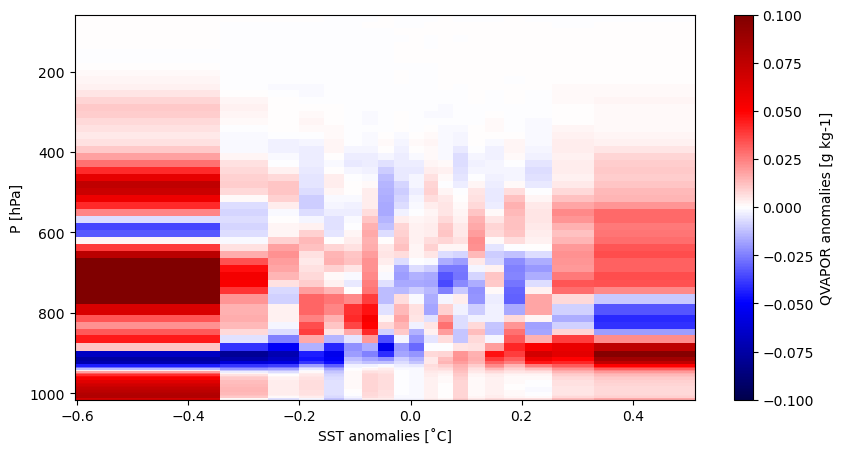

In [16]:
# figure dQVAPOR vs dSST bin - DAILY
fig = plt.figure(figsize=(10, 5))
plt.pcolormesh(pdist_dsst_day, GP, pdist_dqvapor_dsst_day, vmin=-0.1, vmax=0.1, cmap='seismic')
plt.gca().invert_yaxis()
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label('QVAPOR anomalies [g kg-1]')

In [15]:
# path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/anomalies/pvalue_Lcorr/'
# np.savetxt(path_bindist + 'pdist_dQVAPOR_dsst_day_Lcorr30km.txt', pdist_dqvapor_dsst_day)
# np.savetxt(path_bindist + 'pstd_dQVAPOR_dsst_day_Lcorr30km.txt', pstd_dqvapor_dsst_day)
# np.savetxt(path_bindist + 'pstderr_dQVAPOR_dsst_day_Lcorr30km.txt', pstderr_dqvapor_dsst_day)
# np.savetxt(path_bindist + 'pvalue_dQVAPOR_dsst_day_Lcorr30km.txt', pvalue_dqvapor_dsst_day)

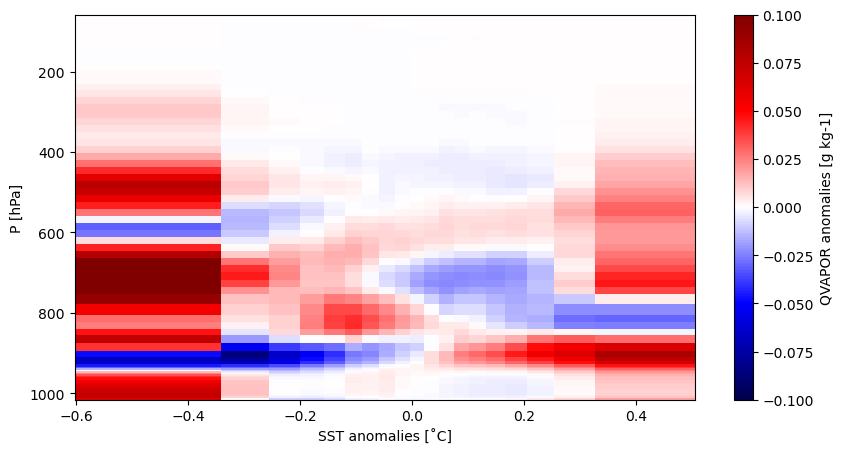

In [18]:
# figure dQVAPOR vs dSST bin - DAILY
fig = plt.figure(figsize=(10, 5))
plt.pcolormesh(pdist_dsst_day, GP, pdist_dqvapor_dsst_day, vmin=-0.1, vmax=0.1, cmap='seismic')
plt.gca().invert_yaxis()
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label('QVAPOR anomalies [g kg-1]')

In [33]:
# # figure dQVAPOR vs dSST bin - DAILY
# fig = plt.figure(figsize=(10, 5))
# plt.pcolormesh(pdist_dsst_day, GP[:33], pdist_dqvapor_dsst_day/pstd_dqvapor_dsst_day*100, vmin=-30, vmax=30, cmap='seismic')
# plt.gca().invert_yaxis()
# plt.xlabel('SST  anomalies[˚C]'); plt.ylabel('P [hPa]')
# cbar = plt.colorbar();  cbar.set_label('QVAPOR anomalies/ std QVAPOR anomalies [%]')
# # aggiungi PBLH o per bin SST o come linea

In [17]:
# path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/perc_dist/daily/anomalies/'
# np.savetxt(path_bindist + 'pdist_dQVAPOR_dsst_day.txt', pdist_dqvapor_dsst_day)
# np.savetxt(path_bindist + 'pstd_dQVAPOR_dsst_day.txt', pstd_dqvapor_dsst_day)
# np.savetxt(path_bindist + 'pstderr_dQVAPOR_dsst_day.txt', pstderr_dqvapor_dsst_day)
# np.savetxt(path_bindist + 'pvalue_dQVAPOR_dsst_day.txt', pvalue_dqvapor_dsst_day)

In [20]:
del QVAPOR_day, dQVAPOR_day

In [ ]:
L = 30
nskip = int(L/3)
nt = int(1)
# from top pbl upwards
Ltop = 150
nskiptop = int(Ltop/3)
nttop = int(1)
# ref mean
popmean = 0.

In [ ]:
# FB DISTRIBUTION dQVAPOR vs dSST bin - DAILY + PVALUE subsampled
perc_step = 5
nbins = int(100/perc_step) # Number of bins.
dist_dQVAPOR_day = np.zeros((dQVAPOR_day.shape[1],nbins))
npoint_dQVAPOR_day = np.zeros((dQVAPOR_day.shape[1],nbins))
stderr_dQVAPOR_day = np.zeros((dQVAPOR_day.shape[1],nbins))
pvalue_dQVAPOR_day = np.zeros((dQVAPOR_day.shape[1],nbins))
for h in range(0,dQVAPOR_day.shape[1]):
    if h % 10 == 0:
        print(h)   
    x = dsst_day.copy(); control = x.reshape(-1)
    y = dQVAPOR_day[:,h].copy(); variable = y.reshape(-1)
    ##### Fixed bin distribution: 
    dist_dsst_day, dist_dQVAPOR_day[h], stderr_dQVAPOR_day[h], npoint_dQVAPOR_day[h], pv = fb_distribution_npoint_pvalue(control, variable, nbins, perc_step, popmean)
    ##### Fixed bin distribution: pvalue on subsampled field
    if h <= 27:
        x = dsst_day[::nt,::nskip,::nskip].copy(); control = x.reshape(-1)
        y = dQVAPOR_day[::nt,h,::nskip,::nskip].copy(); variable = y.reshape(-1)
    else:
        x = dsst_day[::nttop,::nskiptop,::nskiptop].copy(); control = x.reshape(-1)
        y = dQVAPOR_day[::nttop,h,::nskiptop,::nskiptop].copy(); variable = y.reshape(-1)
    dist_control, dist, stderr, npoint, pvalue_dQVAPOR_day[h] = fb_distribution_npoint_pvalue(control, variable, nbins, perc_step, popmean)

In [ ]:
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/anomalies/'
np.savetxt(path_bindist + 'dist_dsst_day.txt', dist_dsst_day)
np.savetxt(path_bindist + 'dist_dQVAPOR_dsst_day.txt', dist_dQVAPOR_day)
np.savetxt(path_bindist + 'npoint_dQVAPOR_dsst_day.txt', npoint_dQVAPOR_day)
np.savetxt(path_bindist + 'stderr_dQVAPOR_dsst_day.txt', stderr_dQVAPOR_day)
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/fb_dist/daily/anomalies/subsampled_pvalue_Lcorr/'
np.savetxt(path_bindist + 'pvalue_dQVAPOR_dsst_day_Lcorr30km-150km.txt', pvalue_dQVAPOR_day)

In [ ]:
# HOURLY tutto da rifare!!!!

In [ ]:
# HOURLY 

In [13]:
# read QVAPOR anomalies
path_dir = '/media/fabien/DAGOBAH1/WRF_EUREC4A/CNT/FEB/01_var_33levels/anomalies/'
qv_files = path_dir + 'QVAPOR_anomalies_150km_d02_2020-02-'
qv_list = sorted(glob.glob(qv_files + '*'))
ds_tmp = xr.open_mfdataset(qv_list, concat_dim='XTIME', combine='nested')

In [14]:
maskl_lon = (ds_tmp.XLONG >= minlon) & (ds_tmp.XLONG <= maxlon)
maskl_lat = (ds_tmp.XLAT >= minlat) & (ds_tmp.XLAT <= maxlat)
ds_q = ds_tmp.where(maskl_lon & maskl_lat, drop=True)

In [15]:
dQVAPOR = ds_q['QVAPOR'].values*seamask

In [ ]:
# DISTRIBUTION dQVAPOR vs dSST bin - HOURLY
str_control = 'SST'; str_variable = "QVAPOR"
perc_step = 5
nbins = int(100/perc_step) # Number of bins.
theshold_n = 100
dist_dqvapor_dsst = np.zeros((dQVAPOR.shape[1],nbins))
npoint_dqvapor_dsst = np.zeros((dQVAPOR.shape[1],nbins))
x = dsst.copy()
control = dsst.reshape(-1)
for h in range(0,dQVAPOR.shape[1]):
    y = dQVAPOR[:,h,:,:].copy()
    variable = y.reshape(-1)
    ##### Fixed bin distribution: fb
    dist_dsst, dist_dqvapor_dsst[h], std_err, npoint_dqvapor_dsst[h] = fb_distribution_mod(control, variable, nbins, theshold_n, perc_step)

In [ ]:
# figure dQVAPOR vs dSST bin - HOURLY
fig = plt.figure(figsize=(10, 5))
plt.pcolormesh(dist_dsst, GP[:33], dist_dqvapor_dsst*1000., vmin=-0.6, vmax=0.6, cmap='seismic')
plt.gca().invert_yaxis()
plt.xlabel('SST anomalies [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label('QVAPOR anomalies [g kg-1]')

In [ ]:
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/'
np.savetxt(path_bindist + 'dist_dsst.txt', dist_dsst)
np.savetxt(path_bindist + 'dist_dQVAPOR_dsst.txt', dist_dqvapor_dsst)
np.savetxt(path_bindist + 'npoint_dQVAPOR_dsst.txt', npoint_dqvapor_dsst)

In [16]:
# DISTRIBUTION dQVAPOR vs SST bin - HOURLY
str_control = 'SST'; str_variable = "QVAPOR"
perc_step = 5
nbins = int(100/perc_step) # Number of bins.
theshold_n = 100
dist_dqvapor_sst = np.zeros((dQVAPOR.shape[1],nbins))
npoint_dqvapor_sst = np.zeros((dQVAPOR.shape[1],nbins))
x = sst.copy()
control = x.reshape(-1)
for h in range(0,dQVAPOR.shape[1]):
    y = dQVAPOR[:,h,:,:].copy()
    variable = y.reshape(-1)
    ##### Fixed bin distribution: fb
    dist_sst, dist_dqvapor_sst[h], std_err, npoint_dqvapor_sst[h] = fb_distribution_mod(control, variable, nbins, theshold_n, perc_step)

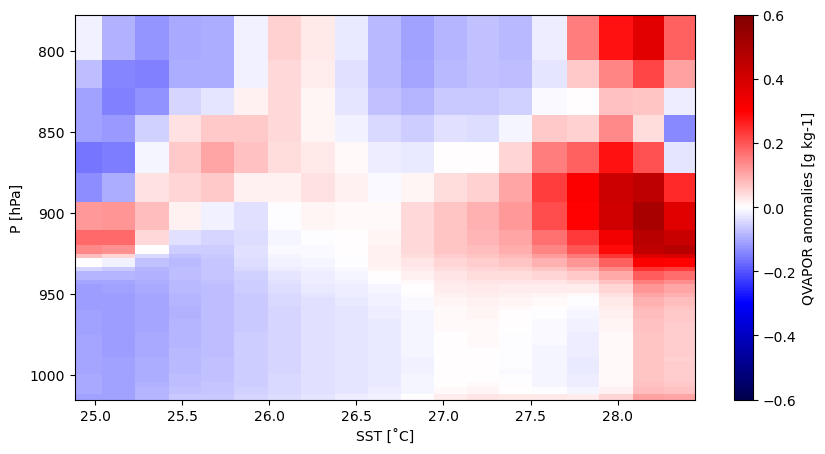

In [19]:
# figure dQVAPOR vs SST bin - HOURLY
fig = plt.figure(figsize=(10, 5))
plt.pcolormesh(dist_sst-273.15, GP[:33], dist_dqvapor_sst*1000., vmin=-0.6, vmax=0.6, cmap='seismic')
plt.gca().invert_yaxis()
plt.xlabel('SST [˚C]'); plt.ylabel('P [hPa]')
cbar = plt.colorbar();  cbar.set_label('QVAPOR anomalies [g kg-1]')

In [23]:
path_bindist = '/home/matteo/Eureca/COARE35/Results/acquistapace_bindist/'
np.savetxt(path_bindist + 'dist_sst.txt', dist_sst)
np.savetxt(path_bindist + 'dist_dQVAPOR_sst.txt', dist_dqvapor_sst)
np.savetxt(path_bindist + 'npoint_dQVAPOR_sst.txt', npoint_dqvapor_sst)